# Training an Anomalous Jet Detector with **RNN** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet image into a low-dimension laten space and, from there, reconstruct the input image. The distance between the input and te output is used to identify rare jet configurations. Applying a lower treshold on the loss, one can veto standard QCD jets (quarks and gluons) and select a sample enriched in anomalous jets (W, Z, top, etc). The model uses (De)Conv2D and Dense layers to process the image.

This is based on the following papers:
- https://arxiv.org/pdf/1808.08992.pdf
- https://arxiv.org/pdf/1808.08979.pdf

For details on the dataset, see Notebook1 and Notebook3

---

In [3]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [5]:
! git clone https://github.com/pierinim/tutorials.git

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [6]:
! ls tutorials/HiggsSchool/data

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [7]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5',
           'tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetList.shape)

Appending tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [8]:
jetList_standard = jetList[np.argmax(target,axis=1)<2]
jetList_W = jetList[np.argmax(target,axis=1)==2]
jetList_Z = jetList[np.argmax(target,axis=1)==3]
jetList_t = jetList[np.argmax(target,axis=1)==4]
print(jetList_standard.shape, jetList_W.shape, jetList_Z.shape, jetList_t.shape)

(19908, 100, 16) (10015, 100, 16) (10037, 100, 16) (10040, 100, 16)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [9]:
label_standard = target[np.argmax(target,axis=1)<2]
del target

We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, label_train, label_val = t= train_test_split(jetList_standard, label_standard, test_size=0.5)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape)
len_val = X_val.shape[0]
X_test = X_val[int(len_val/2.):,:,:]
label_test = label_val[int(len_val/2.):,:]
X_val = X_val[:int(len_val/2.),:,:]
label_test = label_val[:int(len_val/2.),:]
print(X_train.shape, X_val.shape, X_test.shape, label_train.shape, label_val.shape, label_test.shape)

(9954, 100, 16) (9954, 100, 16) (9954, 5) (9954, 5)
(9954, 100, 16) (4977, 100, 16) (4977, 100, 16) (9954, 5) (9954, 5) (4977, 5)


In [11]:
# some cleanup to save memory
del jetList, jetList_standard

# Building the ConvAE model

In [15]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, GRU, Activation
from keras.layers import RepeatVector, Reshape
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [16]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25
print(featureArrayLength)

(100, 16)


In [17]:
#---------
# Enncoder
#---------
inputList = Input(shape=(featureArrayLength))
x = GRU(20, activation="tanh", recurrent_activation='hard_sigmoid', return_sequences=False)(inputList)
x = Dense(5, activation='relu')(x)
x = Dense(20, activation='relu')(x)
x = RepeatVector(featureArrayLength[0])(x)
outputList = GRU(16, activation="tanh", recurrent_activation='hard_sigmoid', return_sequences=True, return_state=False)(x)
####
#
autoencoder = Model(inputs=inputList, outputs=outputList)
#
#autoencoder = Model(inputs=inputList, outputs=x)

In [18]:
autoencoder.compile(loss='%cat', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 16)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2220      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 20)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 16)           1776      
Total params: 4,221
Trainable params: 4,221
Non-trainable params: 0
_________________________________________________________________


We now train the model. Notice the difference with respect to the supervised case
- the input to the training is (X,X) and nor (X, y). Similarly for the validation dataset
- the model has no dropout. It is difficult for an unsupervised model to overtran, so there is not really a need

In [22]:
batch_size = 128
n_epochs = 100

In [23]:
# train 
history = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 9954 samples, validate on 4977 samples
Epoch 1/100
 - 9s - loss: 461.5776 - val_loss: 464.9009
Epoch 2/100
 - 9s - loss: 460.4969 - val_loss: 464.2467
Epoch 3/100
 - 10s - loss: 460.0882 - val_loss: 464.0253
Epoch 4/100
 - 10s - loss: 459.9628 - val_loss: 463.9561
Epoch 5/100
 - 10s - loss: 459.9130 - val_loss: 463.9137
Epoch 6/100
 - 10s - loss: 459.8715 - val_loss: 463.8793
Epoch 7/100
 - 10s - loss: 459.8435 - val_loss: 463.8536
Epoch 8/100
 - 10s - loss: 459.8241 - val_loss: 463.8455
Epoch 9/100
 - 9s - loss: 459.8203 - val_loss: 463.8436
Epoch 10/100
 - 10s - loss: 459.8190 - val_loss: 463.8430
Epoch 11/100
 - 11s - loss: 459.8181 - val_loss: 463.8420
Epoch 12/100
 - 10s - loss: 459.8182 - val_loss: 463.8421
Epoch 13/100
 - 10s - loss: 459.8170 - val_loss: 463.8407
Epoch 14/100
 - 10s - loss: 459.8160 - val_loss: 463.8399
Epoch 15/100
 - 10s - loss: 459.8155 - val_loss: 463.8398
Epoch 16/100
 - 10s - loss: 459.8158 - val_loss: 463.8398
Epoch 17/100
 - 9s - loss: 459.8152 

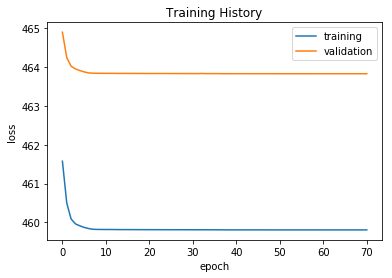

In [31]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We save on disk the best model, result of the training, to be then use for inference

In [25]:
model_json = autoencoder.to_json()
with open("tutorials/HiggsSchool/models/jetAE_RNN.json", "w") as json_file:
    json_file.write(model_json)
autoencoder.save_weights("tutorials/HiggsSchool/models/jetAE_RNN.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'tutorials/HiggsSchool/models/jetAE_RNN.json'

# Loss Distributions

In [46]:
labels = ['W', 'Z', 'top']

In [47]:
anomaly = [jetList_W, jetList_Z, jetList_t]
predictedQCD = autoencoder.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(autoencoder.predict(anomaly[i]))

In [48]:
def mse(List_in, List_out):
    mse = (List_out-List_in)*(List_out-List_in)
    # sum over features
    mse = np.sum(mse,axis=-1)
    # sum over particles
    mse = np.sum(mse, axis=-1)
    return mse    

In [49]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

In [50]:
print(lossQCD.shape)

(4977,)


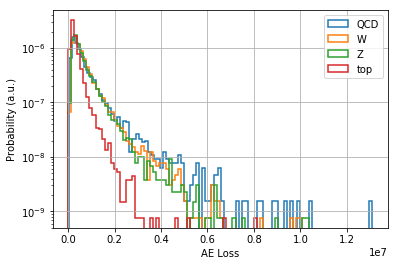

In [53]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
#plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
plt.hist(lossQCD, bins=100, label='QCD', density=True, 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

(10015,) (4977,)
(14992,) (14992,)
(10037,) (4977,)
(15014,) (15014,)
(10040,) (4977,)
(15017,) (15017,)


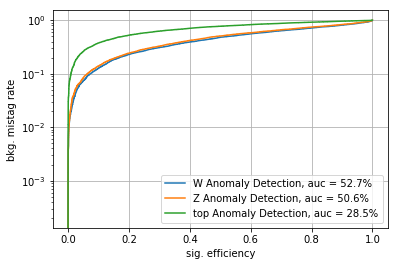

In [54]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()